# Optical Flow
## Sparse Optical Flow

As always start by importing the relevant packages.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils
import glob
import os

Load the images "OF1.jpg" and "OF2.jpg" and change them to grayscale.

In [2]:
def image (a, b):
    img1 = cv2.imread('Stereo_conveyor_without_occlusions_rectified/left/' + str(a))
    img2 = cv2.imread('Stereo_conveyor_without_occlusions_rectified/left/' + str(b))

    b,g,r = cv2.split(img1) # Changing the order from bgr to rgb so that matplotlib can show it
    img1 = cv2.merge([r,g,b])
    b,g,r = cv2.split(img2) # Changing the order from bgr to rgb so that matplotlib can show it
    img2 = cv2.merge([r,g,b])

    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    return gray1, gray2, img2

    #plt.figure(figsize = (18,18))
    #plt.subplot(1,2,1)
    #plt.imshow(gray1, cmap = 'gray')
    #plt.subplot(1,2,2)
    #plt.imshow(gray2, cmap = 'gray')

In [3]:
def img_list(str):
    glb = glob.glob(str)
    lst = sorted(glb)
    return lst

Generate a list

In [4]:
left_imglist = img_list('Stereo_conveyor_without_occlusions_rectified/left/*.png')
filename_left=[]
for i in left_imglist:
    filename_left.append((os.path.basename(i)))
right_imglist = img_list('Stereo_conveyor_without_occlusions_rectified/right/*.png')
filename_right=[]
for i in right_imglist:
    filename_right.append((os.path.basename(i)))

Optical flow + dialation and erosion funtion

In [5]:
def filtering(gray1, gray2, img2):
    #gray1, gray2, img2= image(filename_left[i],filename_left[i+1])
    
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.5, 0)
    mag, angle =cv2.cartToPolar(flow[..., 0], flow[...,1])

    mask=np.zeros_like(img2)

    mask[...,1]=255
    mask[...,0]= angle*180/np.pi/2
    mask[...,2]=cv2.normalize(mag,None,0,255, cv2.NORM_MINMAX)

    rgb= cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    
    kernel=np.ones((5,5))
    ero=cv2.erode(rgb,kernel, iterations=4)
    plt.imshow(ero)
    dia=cv2.dilate(ero,kernel,iterations=7)
    ero2=cv2.erode(dia,kernel, iterations=3)
    
    #plt.imshow(ero2)
    final=img2+ero2
    
    dia3=cv2.dilate(ero2,kernel,iterations=20)
    ero3=cv2.erode(dia3,kernel,iterations=22)
    
    
    gray=cv2.cvtColor(ero3, cv2.COLOR_RGB2GRAY)
    threshold = 10
    threshold_value =255

    thresh = cv2.threshold(gray, threshold, threshold_value, cv2.THRESH_BINARY)[1]
    #plt.imshow(thresh, cmap='gray')
    return thresh

The biggest blob is the box

In [6]:
def biggest(thresh):
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    #print(cnts)
    text = "I found {} objects!".format(len(cnts))
    print(text)
    #print (cv2.contourArea(cnts[0]))
    #print (cv2.contourArea(cnts[1]))
    #print (cv2.contourArea(cnts[2]))
    #print (cv2.contourArea(cnts[3]))
    #print (cv2.contourArea(cnts[4]))

    largest_area=0
    current_area=0
    index=0

    for c in range(len(cnts)):
        current_area=cv2.contourArea(cnts[c])
        if current_area>largest_area:
            largest_area=current_area
            index=c
        
    print(index)
    return index, cnts

Finding the center and saving the image

I found 5 objects!
2
499 246
I found 5 objects!
3
498 250
I found 3 objects!
2
518 202
I found 6 objects!
3
501 253
I found 3 objects!
1
496 258
I found 5 objects!
2
499 251
I found 6 objects!
4
579 149
I found 5 objects!
0
485 260
I found 3 objects!
2
582 131
I found 3 objects!
2
416 112
I found 5 objects!
0
488 274
I found 6 objects!
0
277 381
I found 3 objects!
1
576 176
I found 2 objects!
0
692 199
I found 4 objects!
1
479 291
I found 3 objects!
1
569 178
I found 5 objects!
4
432 93
I found 4 objects!
1
585 134
I found 7 objects!
5
487 103
I found 3 objects!
1
626 129
I found 4 objects!
1
555 182
I found 6 objects!
2
554 183
I found 6 objects!
5
535 20
I found 5 objects!
3
526 151
I found 5 objects!
4
539 26
I found 3 objects!
2
529 28
I found 6 objects!
5
539 23
I found 4 objects!
1
62 305
I found 6 objects!
0
465 372
I found 3 objects!
1
662 133
I found 8 objects!
7
638 137
I found 9 objects!
8
571 105
I found 3 objects!
2
596 111
I found 8 objects!
7
531 25
I found 4 objects!
3


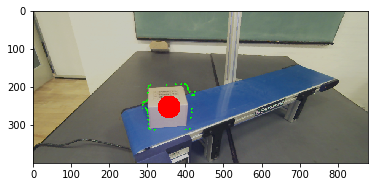

In [9]:
for i in range(0,240):
    
    gray1, gray2, img2= image(filename_left[i],filename_left[i+1])
    thresh=filtering(gray1, gray2, img2)
    index, cnts=biggest(thresh)
    output = img2.copy()
    
    cnt = cnts[index]
    for c in cnt:
        # draw each contour on the output image with a 3px thick black outline
        cv2.drawContours(output, [c], -1, (0, 255, 0), 3)
    #cnt = cnts[index]
    M = cv2.moments(cnt)
    #print( M )
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    print(cx,cy)
    center_coordinates=(cx,cy)
    circle=cv2.circle(output.copy(),center_coordinates,30,(255,0,0),cv2.FILLED)#circle --> center and radius also filled colour
    plt.imshow(circle)
    cv2.imwrite(str(filename_left[i]), circle)